In [292]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests

base_url = "http://localhost:8888/files"
token = "96b93bbc6a79d96d1b473f5d216b4c5439e21833db49cdaa"

start_date = "2023-03-01"
end_date = "2023-09-01"

visit_path = f"https://data-charts-api.hexlet.app/visits?begin={start_date}&end={end_date}"
registration_path= f"https://data-charts-api.hexlet.app/registrations?begin={start_date}&end={end_date}"

visit = requests.get(visit_path).json()
reg = requests.get(registration_path).json()

visits_df = pd.DataFrame(data = visit)
registrations_df = pd.DataFrame(data = reg)

print(visits_df)
print(registrations_df)

ads_path = "data-analytics-project-100/ads.csv"

def load_data(path):
    url = f"{base_url}/{path}?token={token}&start_date={start_date}&end_date={end_date}"
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(pd.io.common.BytesIO(response.content))
    else:
        raise ValueError(f"Ошибка загрузки данных из {path}")
        
ads_df = load_data(ads_path)
ads_df['date'] = pd.to_datetime(ads_df['date']).dt.date

                                    visit_id platform  \
0       1de9ea66-70d3-4a1f-8735-df5ef7697fb9      web   
1       f149f542-e935-4870-9734-6b4501eaf614      web   
2       08f0ebd4-950c-4dd9-8e97-b5bdf073eed1      web   
3       19322fed-157c-49c6-b16e-2d5cabeb9592      web   
4       04762a22-3c9f-40c9-9ac9-6628c4381836      web   
...                                      ...      ...   
263454  6d2e2f5b-970b-4dfe-8f57-25711a5b2a5d      web   
263455  1d91535e-d984-4f76-bbaa-c14c0fd4f2e2      web   
263456  f2496721-7126-430d-976e-777a6cdccb4f      web   
263457  f2496721-7126-430d-976e-777a6cdccb4f      web   
263458  73047125-de44-4d65-8229-7218acff4ddc      web   

                                               user_agent             datetime  
0       Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T10:36:22  
1       Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...  2023-03-01T06:25:00  
2       Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...  2023-03-01T10

In [293]:
print("Визиты: ")
print(visits_df.describe())
print("\n Регистрация: ")
print(registrations_df.describe())
print("\n Реклама: ")
print(ads_df.describe())
#последний визит - уникальный!!!!

visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
registrations_df['datetime'] = pd.to_datetime(registrations_df['datetime']).dt.date
ads_df['date'] = pd.to_datetime(ads_df['date']).dt.date 

# удаление ботов 
visits_df = visits_df[~visits_df['user_agent'].str.contains('bot', case=False, na=False)]
visits_df = visits_df.sort_values(by=['visit_id', 'datetime'], ascending=[True, False])
visits_df = visits_df.drop_duplicates(subset=['visit_id'],keep='last')
visits_df['datetime'] = visits_df['datetime'].dt.date

# агрегация по дате и платформе
visits_agg = visits_df.groupby(['datetime', 'platform']).agg(visits=('visit_id', 'count')).reset_index()
# visits_agg = visits_df.groupby(['datetime', 'platform']).size().reset_index()
# visits_agg = visits_df.groupby(['datetime', 'platform']).size().reset_index(name='visits')

# оставляем только последнюю регистрацию каждого пользователя
registrations_agg = registrations_df.groupby(['datetime', 'platform']).agg(registrations=('user_id', 'count')).reset_index()

# объединение 
conversion_df = pd.merge(visits_agg, registrations_agg, on=['datetime', 'platform'], how='left').fillna(0)
conversion_df['conversion'] = (conversion_df['registrations'] / conversion_df['visits']) * 100

# агрегация по рекламе
ads_agg = ads_df.groupby(['date', 'utm_campaign']).agg(cost=('cost', 'sum')).reset_index()

final_df = pd.merge(conversion_df, ads_agg, left_on='datetime', right_on='date', how='left')
final_df['cost'] = final_df['cost'].fillna(0)  # замена NaN на 0 в столбце cost
final_df['utm_campaign'] = final_df['utm_campaign'].fillna('')  # замена NaN на пустую строку в utm_campaign

final_df = final_df.sort_values(by='datetime').reset_index(drop=True)

final_df.to_json('ads.json', orient='columns')
print(final_df.head())

Визиты: 
                                    visit_id platform  \
count                                 263459   263459   
unique                                146085        4   
top     64167edd-323a-4ab0-be9b-acd237a1ac30      web   
freq                                       4   236301   

                                               user_agent             datetime  
count                                              263459               263459  
unique                                                 32               261204  
top     Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...  2023-07-06T10:45:50  
freq                                                13623                    3  

 Регистрация: 
                   datetime                               user_id  \
count                 21836                                 21836   
unique                21821                                 21836   
top     2023-06-23T13:10:45  2e0f6bb8-b029-4f45-a786-2b53990d37f1   
freq    

## Визуализация
### Итоговые визиты

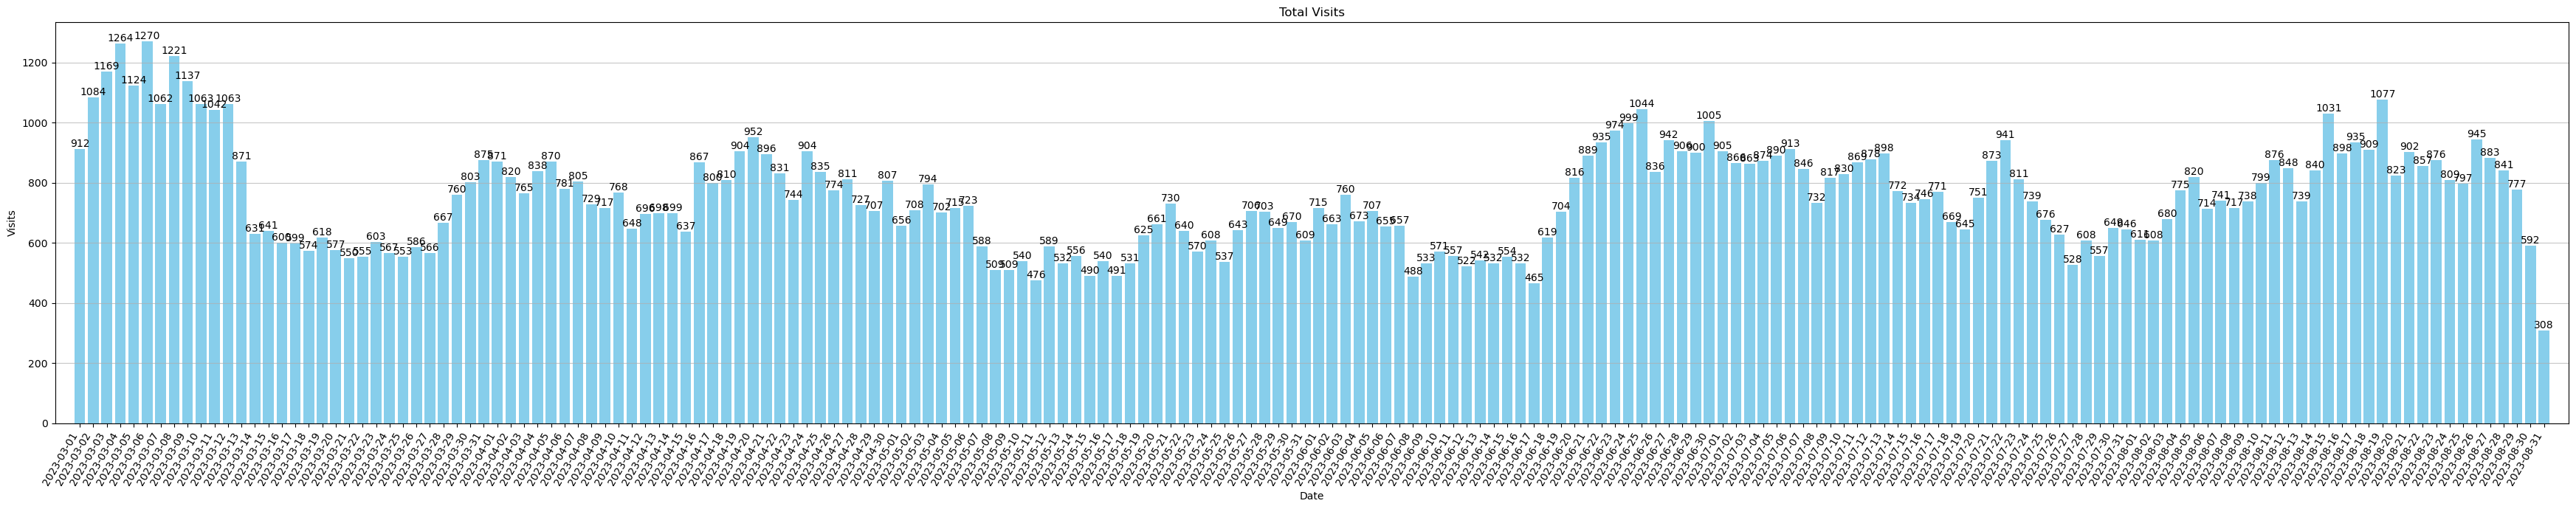

In [356]:
visits_by_date = visits_df.groupby("datetime")["visit_id"].nunique().reset_index()
plt.figure(figsize=(35, 7))
bars = plt.bar(visits_by_date["datetime"], visits_by_date["visit_id"], color="skyblue")
plt.bar_label(bars, labels=[f'{int(value)}' for value in visits_by_date["visit_id"]], label_type="edge")

plt.xlabel("Date")
plt.ylabel("Visits")
plt.title("Total Visits")
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.xticks(visits_by_date["datetime"], rotation=60, ha="right") 
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

padding = (visits_by_date["datetime"].max() - visits_by_date["datetime"].min()) * 0.01  # 1% от ширины
plt.xlim(visits_by_date["datetime"].min() - padding, visits_by_date["datetime"].max() + padding)

plt.savefig("total_visits.png", format="png")
plt.tight_layout()
plt.show()

### Итоговые визиты с разбивкой по платформам: web, android, ios

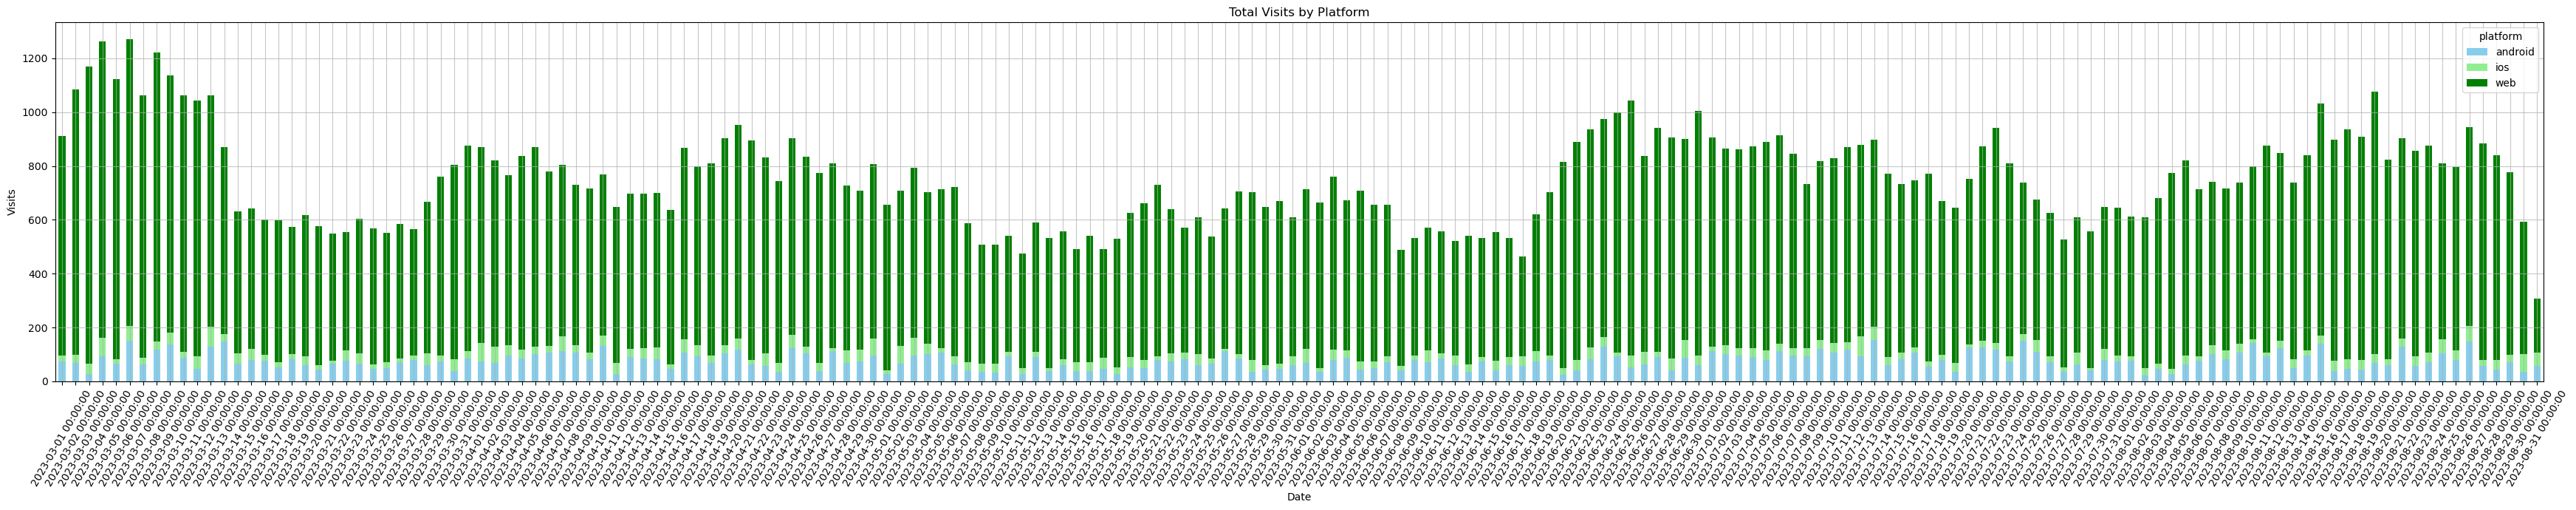

In [357]:
visits_agg = visits_df.groupby(["datetime", "platform"])["visit_id"].count().unstack(fill_value=0)

visits_agg.plot(kind="bar", stacked=True, color=["skyblue", "lightgreen", "green"], figsize=(35, 7))

plt.xlabel("Date")
plt.ylabel("Visits")
plt.title("Total Visits by Platform")
plt.xticks(rotation=60)  
plt.tight_layout()
plt.grid(linestyle='-', alpha=0.7)
plt.savefig("total_visits_stacked.png", format="png") 
plt.show()

### Итоговые регистрации

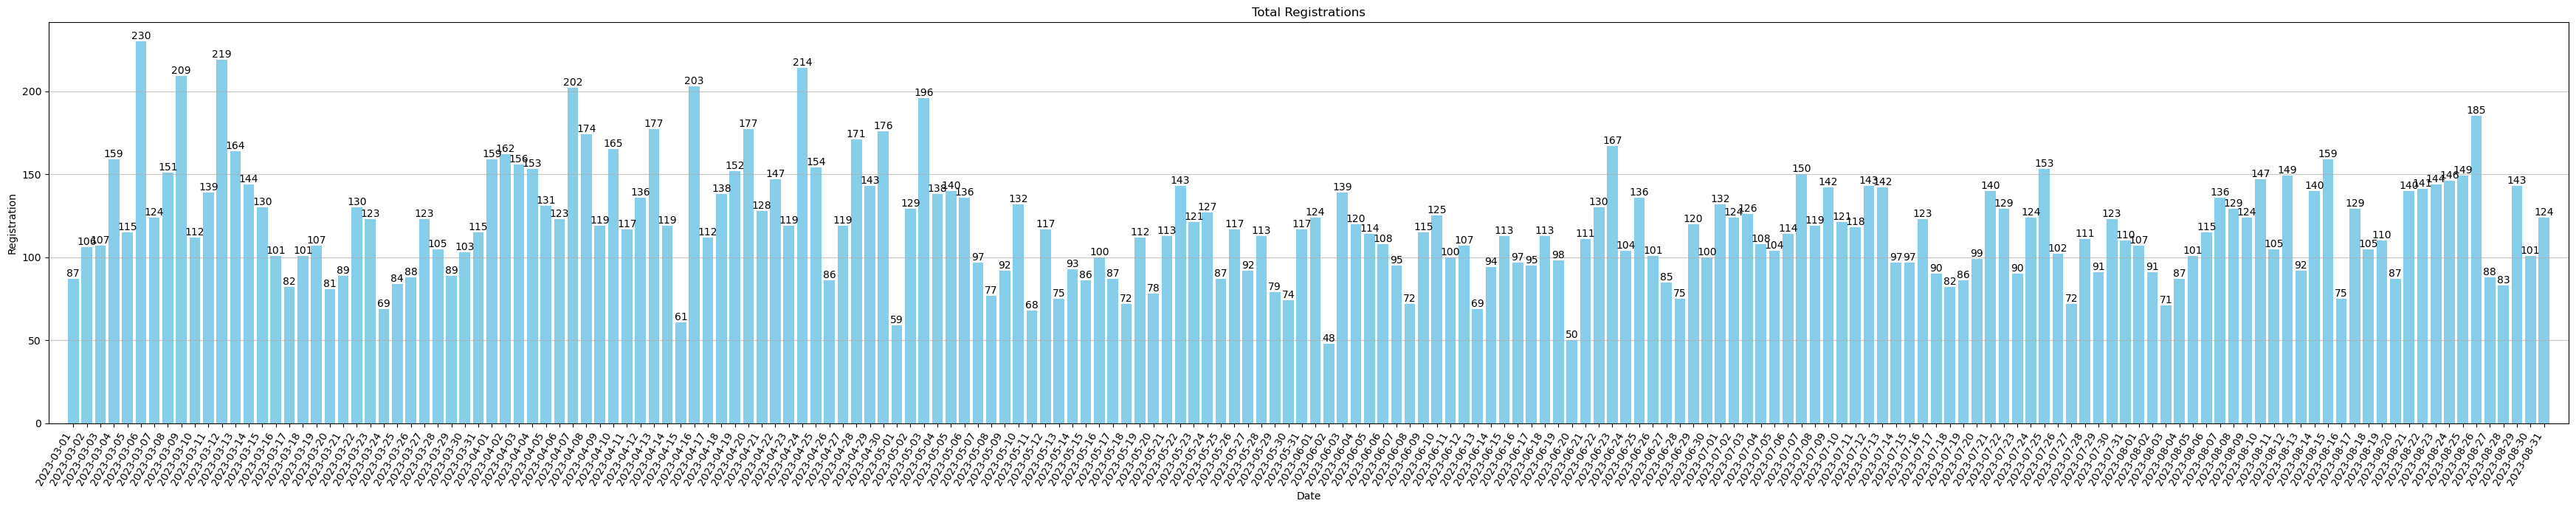

In [358]:
registrarion_by_date = registrations_df.groupby("datetime")["user_id"].nunique().reset_index()
plt.figure(figsize=(35, 7))

bars = plt.bar(registrarion_by_date["datetime"], registrarion_by_date["user_id"], color="skyblue")
plt.bar_label(bars, labels=[f'{int(value)}' for value in registrarion_by_date["user_id"]], label_type="edge")

plt.bar(registrarion_by_date["datetime"], registrarion_by_date["user_id"], color="skyblue")
plt.xlabel("Date")
plt.ylabel("Registration")
plt.title("Total Registrations")
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(registrarion_by_date["datetime"], rotation=60, ha="right")
plt.tight_layout()

padding = (visits_by_date["datetime"].max() - visits_by_date["datetime"].min()) * 0.01  # 1% от ширины
plt.xlim(visits_by_date["datetime"].min() - padding, visits_by_date["datetime"].max() + padding)

plt.savefig("total_registrations.png", format="png")
plt.show()

### Итоговые регистрации с разбивкой по платформе: web, android, ios

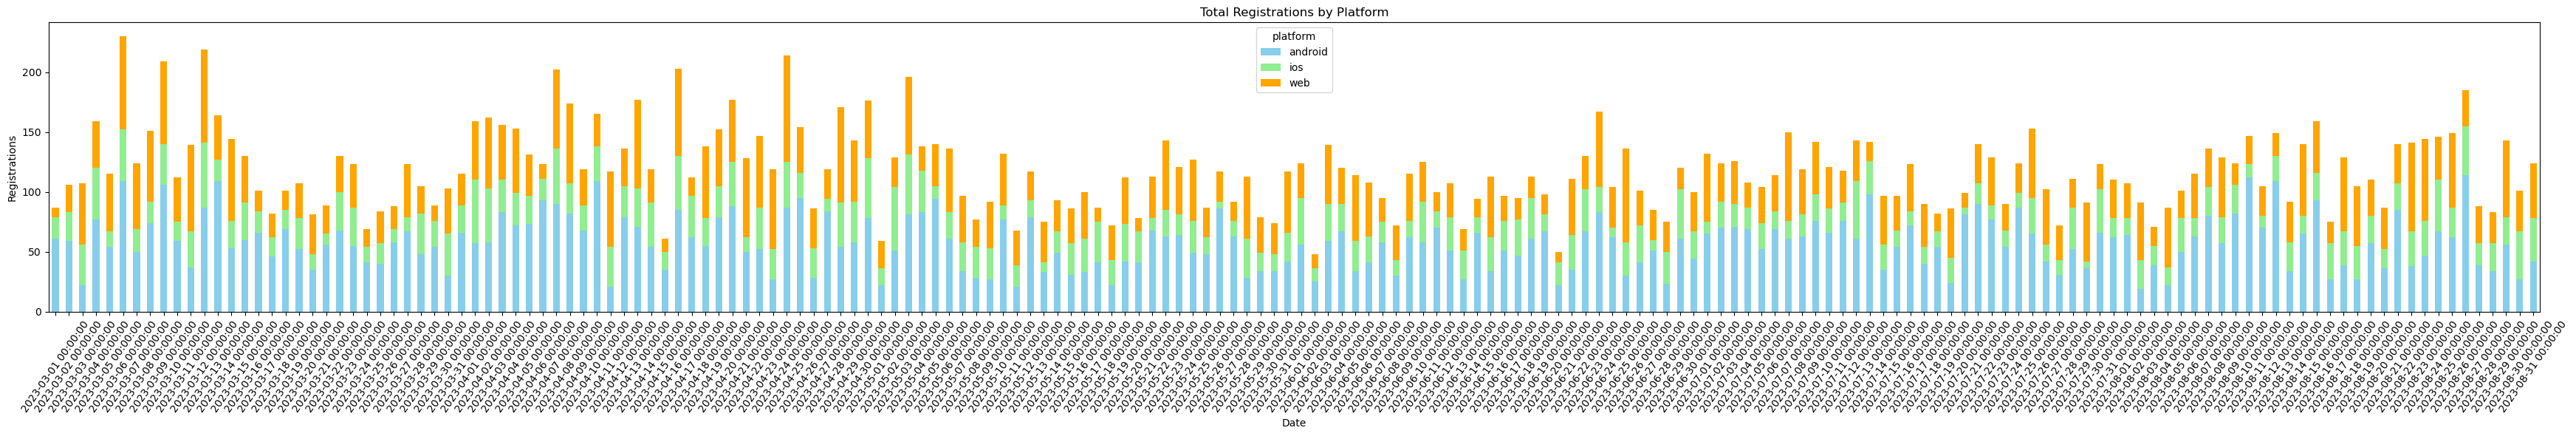

In [359]:
registrations_agg = registrations_df.groupby(["datetime", "platform"])["user_id"].count().unstack(fill_value=0)

registrations_agg.plot(kind="bar", stacked=True, color=["skyblue", "lightgreen", "orange"], figsize=(35, 6))

plt.xlabel("Date")
plt.ylabel("Registrations")
plt.title("Total Registrations by Platform")
plt.xticks(rotation=55)  
plt.tight_layout()
plt.savefig("total_visits_stacked.png", format="png") 
plt.show()

### Итоговые конверсии

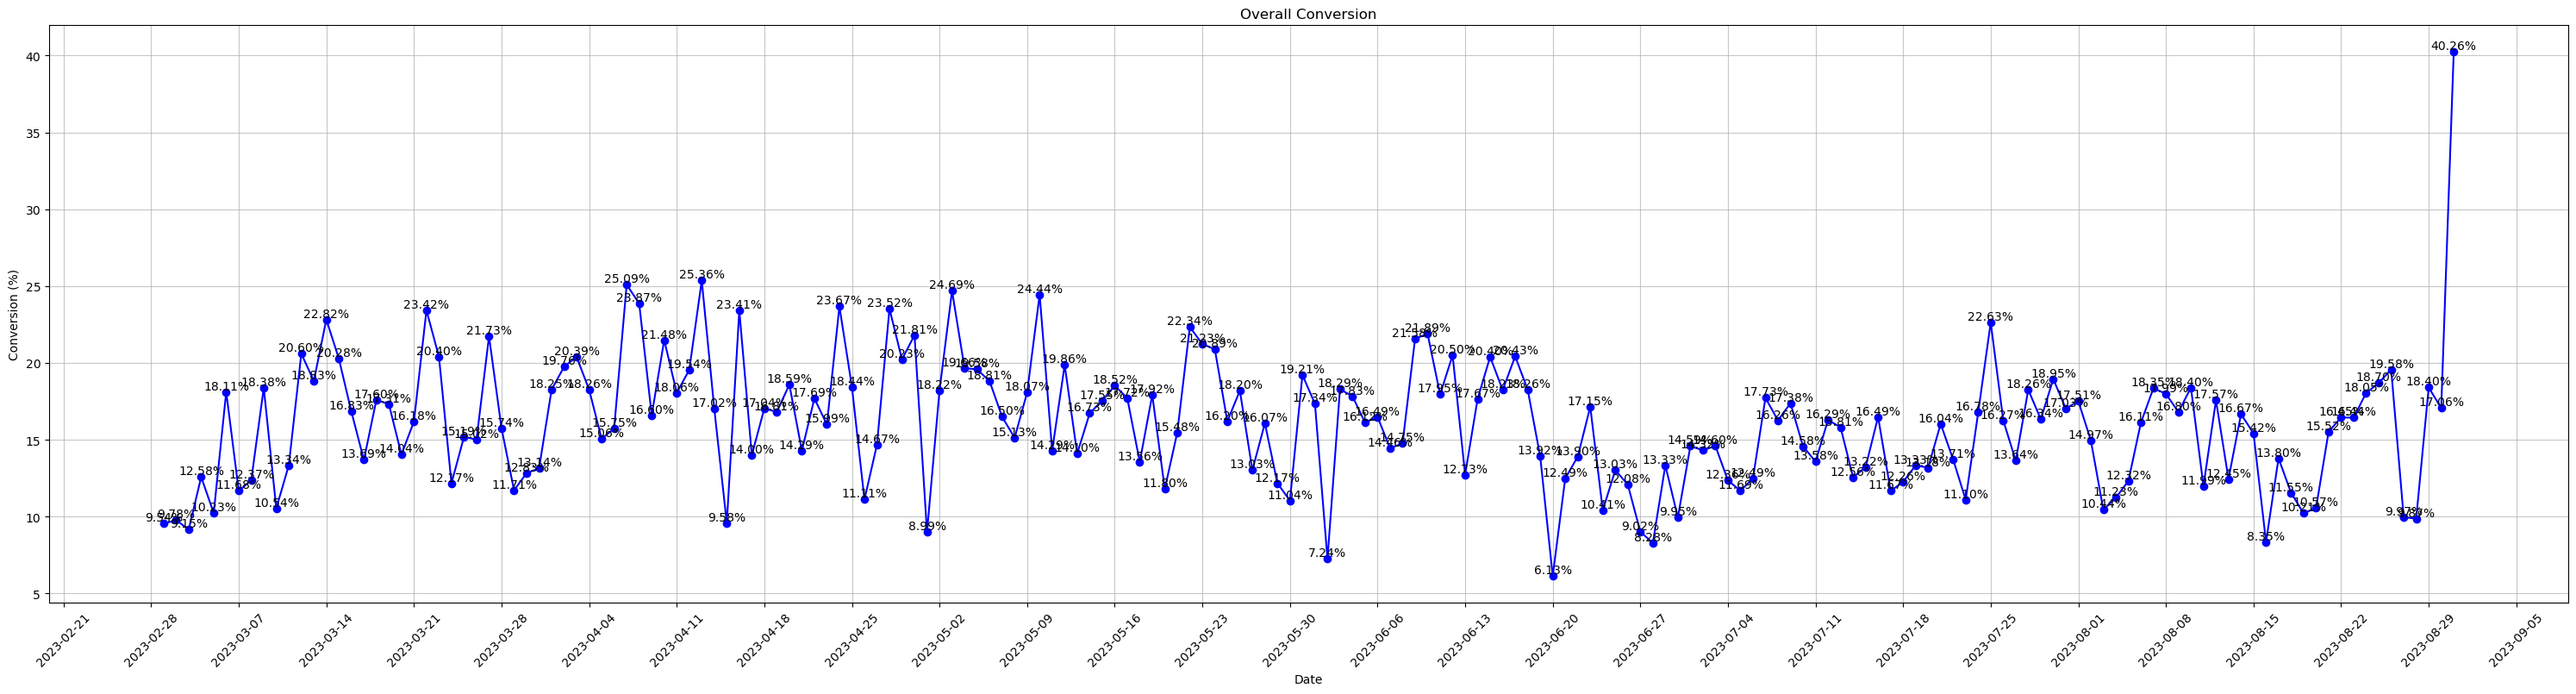

      datetime  visits  registrations  conversion
0   2023-03-01     912             87    9.539474
1   2023-03-02    1084            106    9.778598
2   2023-03-03    1169            107    9.153122
3   2023-03-04    1264            159   12.579114
4   2023-03-05    1124            115   10.231317
..         ...     ...            ...         ...
179 2023-08-27     883             88    9.966025
180 2023-08-28     841             83    9.869203
181 2023-08-29     777            143   18.404118
182 2023-08-30     592            101   17.060811
183 2023-08-31     308            124   40.259740

[184 rows x 4 columns]


In [377]:
import matplotlib.dates as mdates

visits_agg = visits_df.groupby("datetime")["visit_id"].count().reset_index(name="visits")
registrations_agg = registrations_df.groupby("datetime")["user_id"].nunique().reset_index(name="registrations")

conversion_df = pd.merge(visits_agg, registrations_agg, on="datetime", how="left")

conversion_df["conversion"] = (conversion_df["registrations"] / conversion_df["visits"]) * 100

conversion_df["datetime"] = pd.to_datetime(conversion_df["datetime"])

plt.figure(figsize=(30, 8))
plt.plot(conversion_df["datetime"], conversion_df["conversion"], marker='o', color='b', label='Conversion Rate')

for i, row in conversion_df.iterrows():
    plt.text(row["datetime"], row["conversion"], f'{row["conversion"]:.2f}%', ha='center', va='bottom')

plt.title("Overall Conversion")
plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(linestyle='-', alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # недели
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.savefig("conversion_rate_by_date.png", format="png")
plt.show()
print(conversion_df)

### Конверсия по каждой платформе

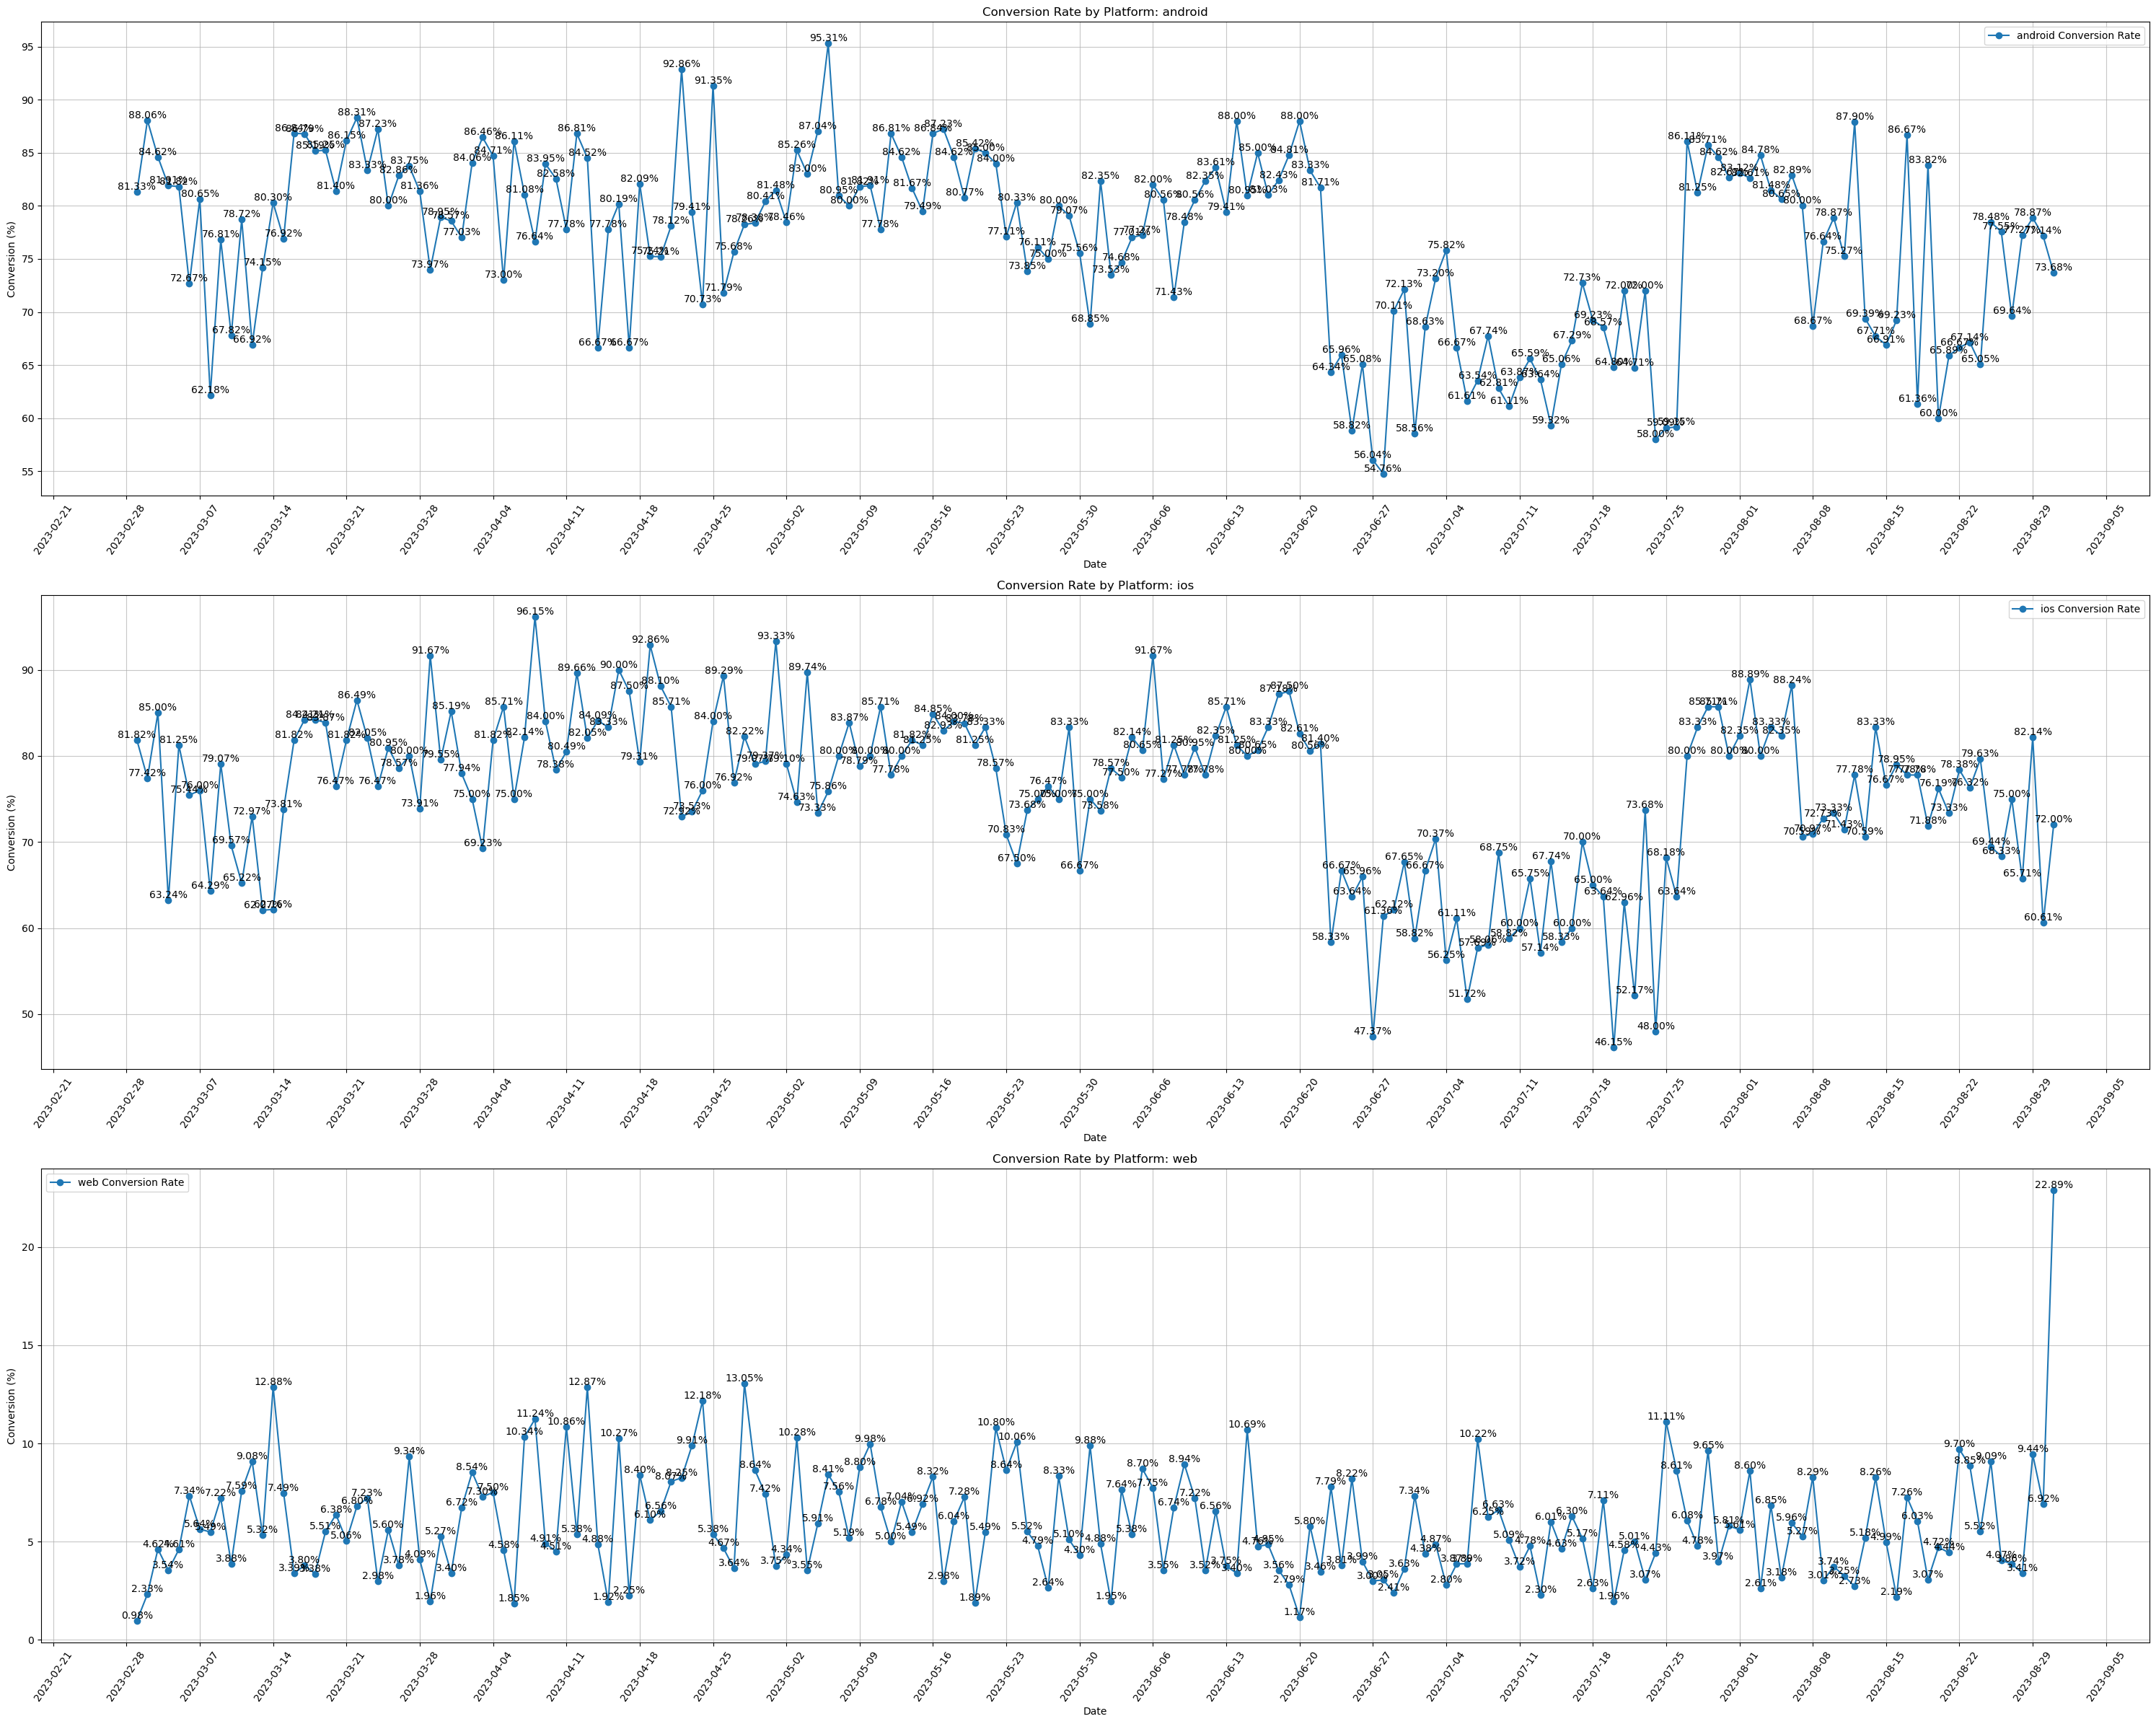

In [376]:
import matplotlib.dates as mdates

visits_agg_platform = visits_df.groupby(["datetime", "platform"])["visit_id"].count().reset_index(name="visits")
registrations_agg_platform = registrations_df.groupby(["datetime", "platform"])["user_id"].nunique().reset_index(name="registrations")

conversion_df_platform = pd.merge(visits_agg_platform, registrations_agg_platform, on=["datetime", "platform"], how="left")
conversion_df_platform["conversion"] = (conversion_df_platform["registrations"] / conversion_df_platform["visits"]) * 100
unique_platforms = conversion_df_platform["platform"].unique()
n_platforms = len(unique_platforms)
fig, axes = plt.subplots(n_platforms, 1, figsize=(30, 8 * n_platforms))

# если один подграфик, то axes будет объектом, преобразуем его в список
if n_platforms == 1:
    axes = [axes]

for i, platform in enumerate(unique_platforms):
    platform_data = conversion_df_platform[conversion_df_platform["platform"] == platform]
    axes[i].plot(platform_data["datetime"], platform_data["conversion"], marker='o', label=f'{platform} Conversion Rate')
    axes[i].set_title(f"Conversion Rate by Platform: {platform}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Conversion (%)")
    axes[i].legend()

    # проценты
    for j, row in platform_data.iterrows():
        axes[i].text(row["datetime"], row["conversion"], f'{row["conversion"]:.2f}%', ha='center', va='bottom')

    axes[i].grid(True, linestyle='-', alpha=0.7)
    axes[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) 
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
    axes[i].tick_params(axis='x', rotation=55) 

plt.tight_layout()
plt.savefig("conversion_all_rate_by_date.png", format="png")

plt.show()

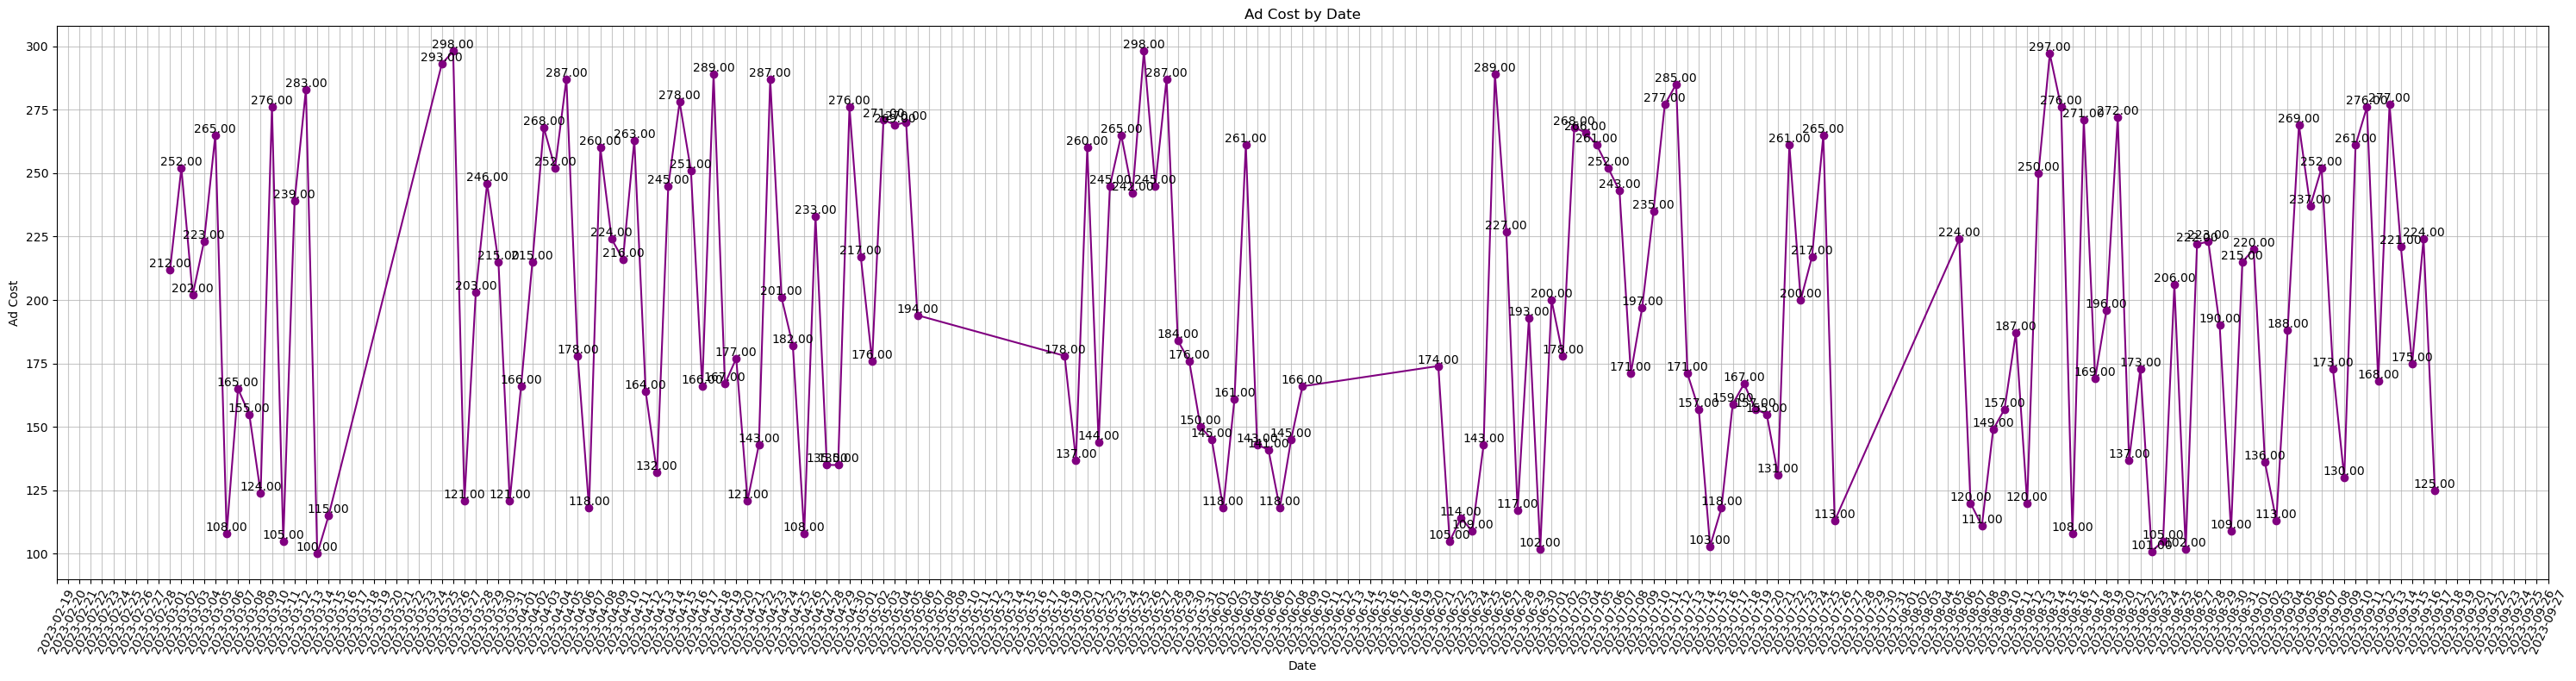

In [371]:
import matplotlib.dates as mdates

ads_agg = ads_df.groupby("date")["cost"].sum().reset_index()
ads_agg["date"] = pd.to_datetime(ads_agg["date"])

plt.figure(figsize=(30, 8))
plt.plot(ads_agg["date"], ads_agg["cost"], marker='o', color='purple', label='Ad Cost')

for i, row in ads_agg.iterrows():
    plt.text(row["date"], row["cost"], f'{row["cost"]:.2f}', ha='center', va='bottom')

plt.title("Ad Cost by Date")
plt.xlabel("Date")
plt.ylabel("Ad Cost")
plt.xticks(rotation=65)
plt.grid(linestyle='-', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.tight_layout()
plt.savefig("Визиты за весь период с цветовым выделением рекламной кампании.png", format="png")
plt.show()

In [153]:
print(ads_)

           date utm_source utm_medium                utm_campaign  cost
0    2023-03-01     google        cpc  advanced_algorithms_series   212
1    2023-03-02     google        cpc  advanced_algorithms_series   252
2    2023-03-03     google        cpc  advanced_algorithms_series   202
3    2023-03-04     google        cpc  advanced_algorithms_series   223
4    2023-03-05     google        cpc  advanced_algorithms_series   265
..          ...        ...        ...                         ...   ...
154  2023-09-13         vk     social      intro_to_python_course   277
155  2023-09-14         vk     social      intro_to_python_course   221
156  2023-09-15         vk     social      intro_to_python_course   175
157  2023-09-16         vk     social      intro_to_python_course   224
158  2023-09-17         vk     social      intro_to_python_course   125

[159 rows x 5 columns]


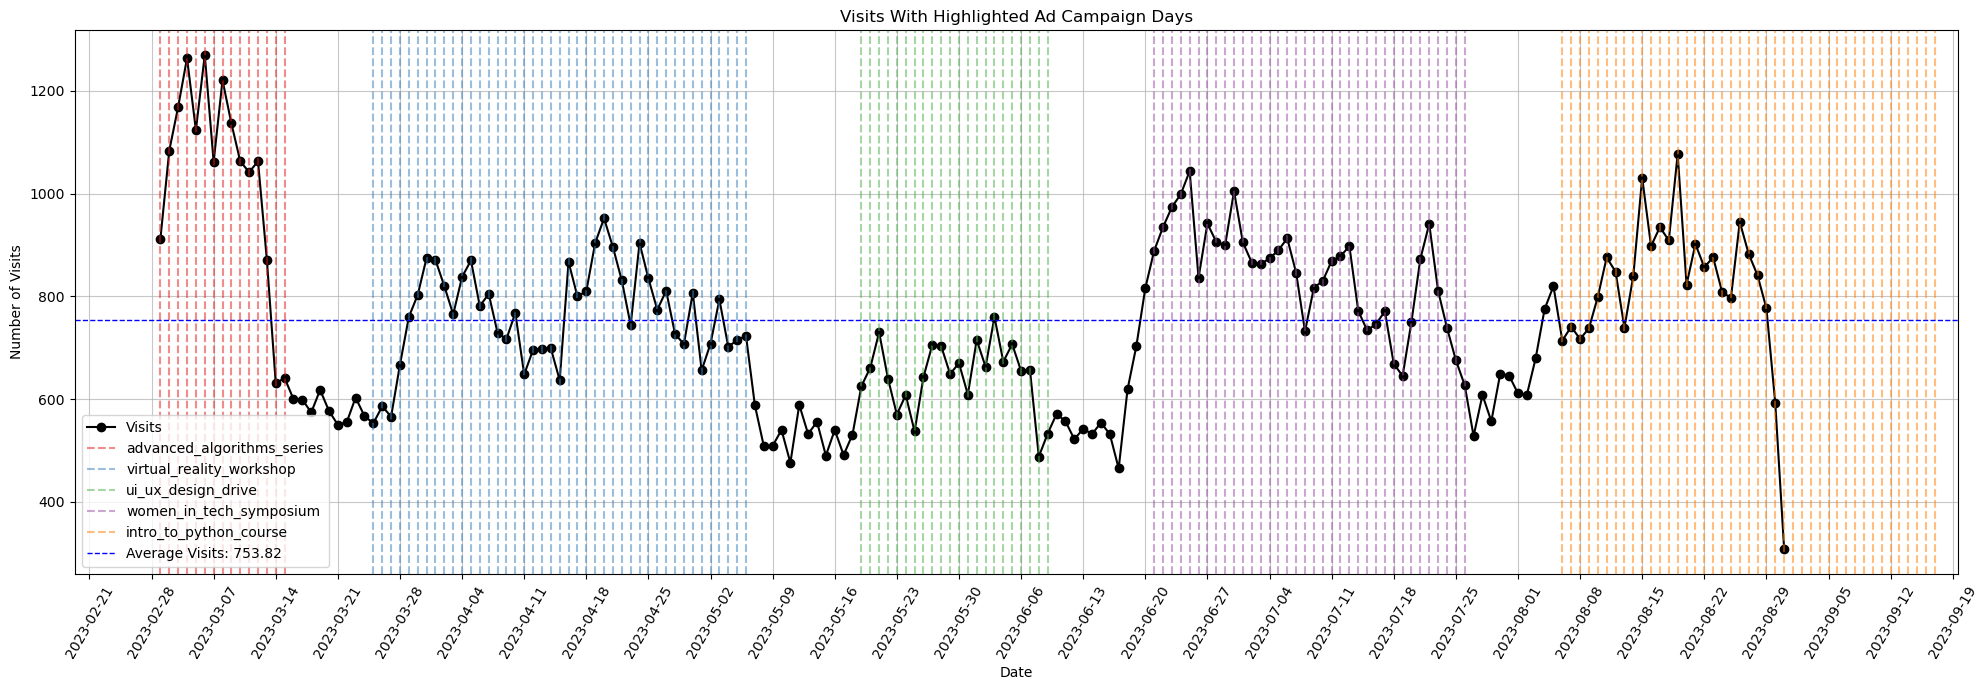

In [375]:
campaign_dates = ads_df[ads_df['utm_campaign'] != '']['date'].unique()
total_visits = visits_df.groupby("datetime")["visit_id"].count().reset_index(name="visits")
unique_campaigns = ads_df[ads_df['utm_campaign'] != '']['utm_campaign'].unique()
cmap = plt.colormaps.get_cmap('Set1')

plt.figure(figsize=(20, 7))
plt.plot(total_visits["datetime"], total_visits["visits"], marker='o', color='black', label='Visits')

for i, campaign in enumerate(unique_campaigns):
    campaign_dates_for_campaign = ads_df[ads_df['utm_campaign'] == campaign]['date'].unique()
    color = cmap(i % cmap.N)  # остаток от деления, чтобы не выйти за пределы cmap
    for date in campaign_dates_for_campaign: # axvline - метод для вертикальных линий
        plt.axvline(pd.to_datetime(date), color=color, linestyle='--', alpha=0.5, label=campaign if date == campaign_dates_for_campaign[0] else "")

average_visits = total_visits["visits"].mean()
plt.axhline(average_visits, color='blue', linestyle='--', linewidth=1, label=f'Average Visits: {average_visits:.2f}')

plt.title("Visits With Highlighted Ad Campaign Days")
plt.xlabel("Date")
plt.ylabel("Number of Visits")
plt.xticks(rotation=60)
plt.grid(linestyle='-', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # недели
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.legend()
plt.tight_layout()
plt.savefig("Visits With Highlighted Ad Campaign Days", format="png")
plt.show()

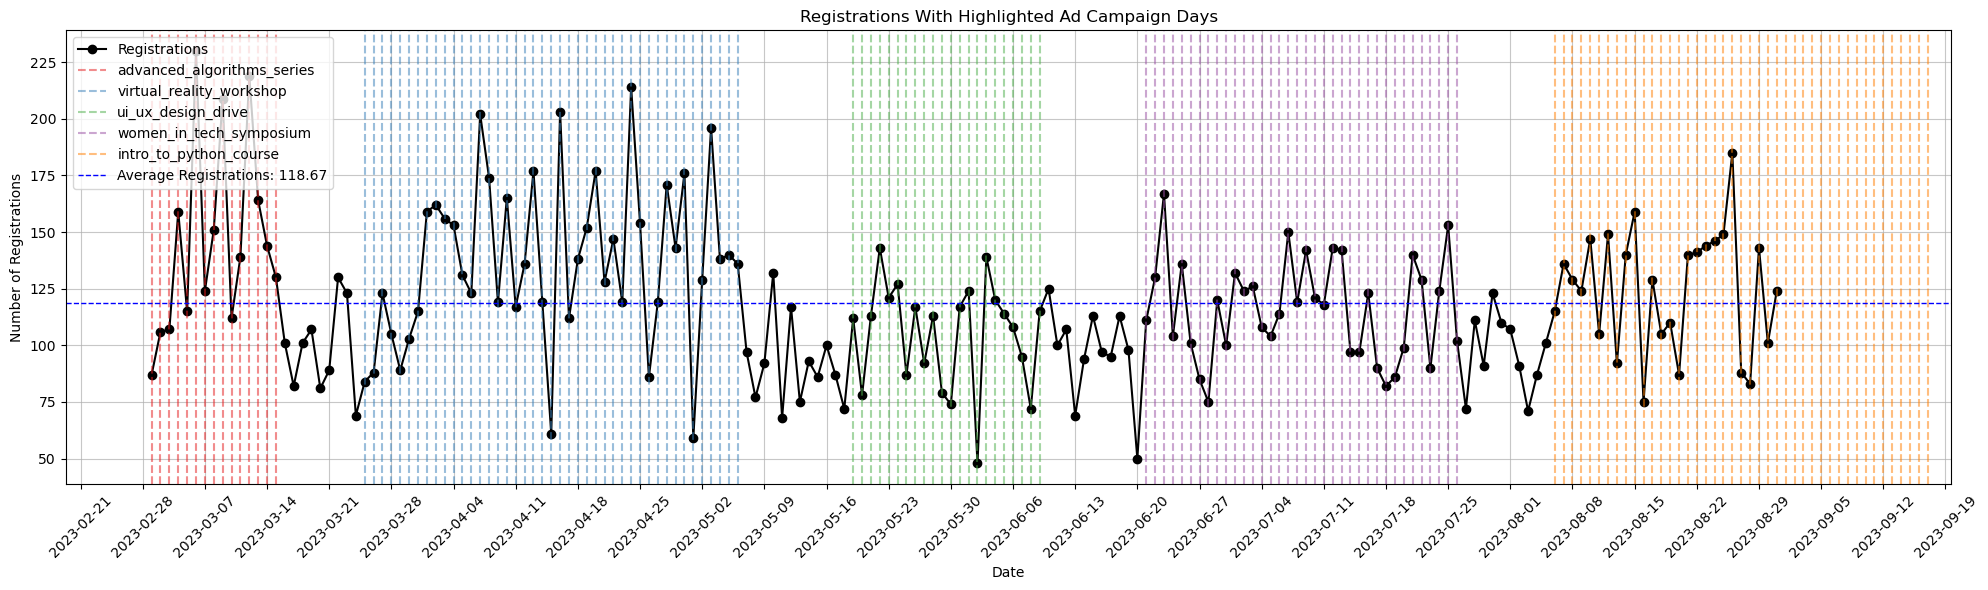

In [374]:
campaign_dates = ads_df[ads_df['utm_campaign'] != '']['date'].unique()
total_registrations = registrations_df.groupby("datetime")["user_id"].nunique().reset_index(name="registrations")
unique_campaigns = ads_df[ads_df['utm_campaign'] != '']['utm_campaign'].unique()
cmap = plt.colormaps.get_cmap('Set1')

plt.figure(figsize=(20, 6))
plt.plot(total_registrations["datetime"], total_registrations["registrations"], marker='o', color='black', label='Registrations')

for i, campaign in enumerate(unique_campaigns):
    campaign_dates_for_campaign = ads_df[ads_df['utm_campaign'] == campaign]['date'].unique()
    color = cmap(i % cmap.N)
    for date in campaign_dates_for_campaign:
        plt.axvline(pd.to_datetime(date), color=color, linestyle='--', alpha=0.5, label=campaign if date == campaign_dates_for_campaign[0] else "")

average_registrations = total_registrations["registrations"].mean()
plt.axhline(average_registrations, color='blue', linestyle='--', linewidth=1, label=f'Average Registrations: {average_registrations:.2f}')

plt.title("Registrations With Highlighted Ad Campaign Days")
plt.xlabel("Date")
plt.ylabel("Number of Registrations")
plt.xticks(rotation=45)
plt.grid(linestyle='-', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend()
plt.tight_layout()
plt.savefig("Registrations Over Time with Highlighted Ad Campaign Days", format="png")
plt.show()